In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import gaussian_kde
from scipy import stats


PDF_FIX_METHOD = "omit"  # or: clip


def _fix_pdf_estimates(pdf_estimates: np.ndarray) -> np.ndarray:
    if PDF_FIX_METHOD == "omit":
        return pdf_estimates[pdf_estimates > 0.0]
    if PDF_FIX_METHOD == "clip":
        return np.clip(pdf_estimates, 1e-10, None)

    raise NotImplementedError()


def log_likelihood(pdf, data):
    return np.log(pdf(data)).mean()


def log_likelihood_estimate_cdf(samples, data, num_quantiles=100):
    # Sort the samples for efficient cumulative likelihood estimation
    sorted_samples = np.sort(samples)

    # Compute empirical CDF values for each data point
    cdf_values = np.searchsorted(sorted_samples, data, side="right") / len(
        sorted_samples
    )
    cdf_values = _fix_pdf_estimates(cdf_values)
    return np.log(cdf_values).mean()


def log_likelihood_estimate_kde(samples, data):
    kde = gaussian_kde(samples)
    pdf_values = kde.evaluate(data)
    pdf_values = _fix_pdf_estimates(pdf_values)
    return np.log(pdf_values).mean()


def _hist_bin_selection(samples, data, method: str):
    eps = np.abs(data).max() * 1e-6

    if method == "extra_bin":
        bin_edges = np.histogram_bin_edges(samples, bins="auto")

        # add an extra bin such that data is always in bins
        if data.min() < bin_edges[0]:
            bin_edges = np.sort([data.min() - eps] + bin_edges.tolist())
        if data.max() >= bin_edges[-1]:
            bin_edges = np.sort(bin_edges.tolist() + [data.max() + eps])

    elif method == "extended_ends":
        bin_edges = np.histogram_bin_edges(samples, bins="auto")
        if data.min() < bin_edges[0]:
            bin_edges[0] = data.min() - eps
        if data.max() >= bin_edges[-1]:
            bin_edges[-1] = data.max() + eps

    elif method == "data_scaled":
        data_scaled = data.copy()
        data_scaled[np.argmin(data)] -= eps
        data_scaled[np.argmax(data)] += eps
        bin_edges = np.histogram_bin_edges(data_scaled, bins="auto")

    else:
        raise ValueError(f"Unknown method: '{method}'")

    return bin_edges


def log_likelihood_estimate_hist(samples, data, method=None):
    # best default (empirically tested)
    if method is None:
        method = "extra_bin" if len(data) > len(samples) else "data_scaled"

    bin_edges = _hist_bin_selection(samples, data, method)

    dens, bin_edges = np.histogram(samples, bin_edges, density=True)

    assert data.min() > bin_edges[0], (data.min(), bin_edges[0])
    assert data.max() < bin_edges[-1], (data.max(), bin_edges[-1])

    data_bin_indices = np.digitize(data, bin_edges) - 1
    pdf_values = dens[data_bin_indices]
    pdf_values = _fix_pdf_estimates(pdf_values)

    return np.log(pdf_values).mean()


def log_likelihood_estimate_hist_all(samples, data):
    total_mean = 0
    methods = ["extended_ends", "extra_bin", "data_scaled"]
    for method in methods:
        bin_edges = _hist_bin_selection(samples, data, method)

        dens, bin_edges = np.histogram(samples, bin_edges, density=True)

        assert data.min() > bin_edges[0], (data.min(), bin_edges[0])
        assert data.max() < bin_edges[-1], (data.max(), bin_edges[-1])

        data_bin_indices = np.digitize(data, bin_edges) - 1
        pdf_values = dens[data_bin_indices]
        pdf_values = _fix_pdf_estimates(pdf_values)

        total_mean += np.log(pdf_values).mean()
    total_mean /= len(methods)
    return total_mean


def _log_likelihood_estimate(quantiles, data):
    likelihood = np.zeros_like(data)
    for quantile in quantiles:
        for i, y in enumerate(data):
            if y < quantile:
                likelihood[i] += 1
    likelihood = likelihood[likelihood > 0.0]
    likelihood /= len(quantiles)
    return np.log(likelihood).mean()


def log_likelihood_estimate(samples, data):
    qs = np.linspace(0, 1, 100)
    quantiles = np.quantile(samples, qs)
    return _log_likelihood_estimate(quantiles, data)

-1.452557725631468
CDF Log Likelihood: -0.9487176082358972


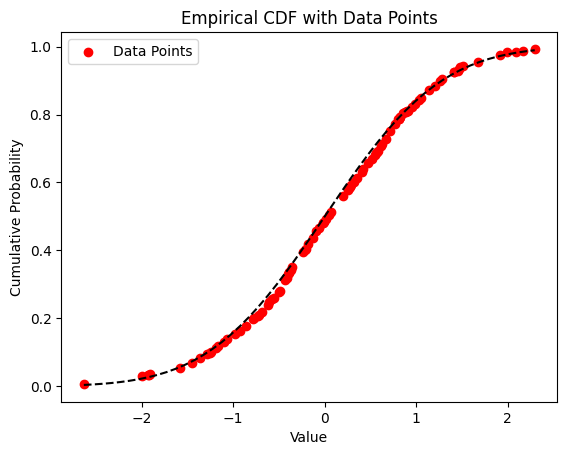

KDE Log Likelihood: -1.442808520238053


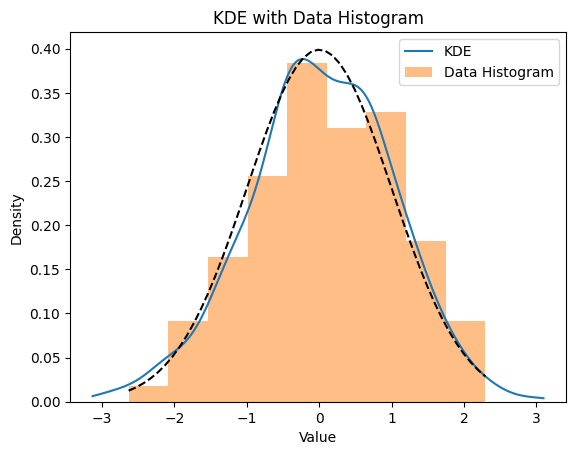

Histogram Log Likelihood: -1.4486882964849326


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


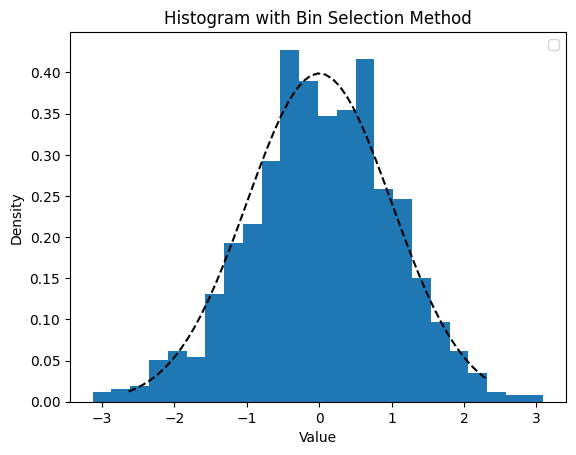

Quantile Log Likelihood: -1.0822569651435445


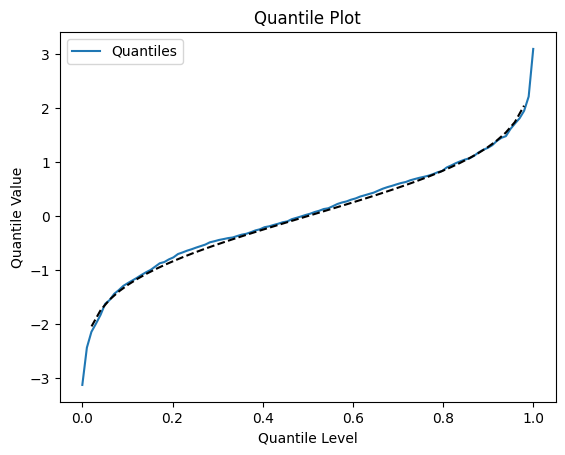

In [254]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde


PDF_FIX_METHOD = "omit"  # or: "clip"


def _fix_pdf_estimates(pdf_estimates: np.ndarray) -> np.ndarray:
    if PDF_FIX_METHOD == "omit":
        return pdf_estimates[pdf_estimates > 0.0]
    if PDF_FIX_METHOD == "clip":
        return np.clip(pdf_estimates, 1e-10, None)
    raise NotImplementedError()


class LogLikelihoodEstimator:
    def __init__(self, samples, data):
        self.samples = samples
        self.data = data

    def log_likelihood(self):
        raise NotImplementedError("Must be implemented in subclasses.")

    def plot(self):
        raise NotImplementedError("Must be implemented in subclasses.")


class CDFLogLikelihoodEstimator(LogLikelihoodEstimator):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def log_likelihood(self):
        self.sorted_samples = np.sort(self.samples)
        # np.searchsorted(sorted_samples, data, side="right") / len(sorted_samples)
        # np.searchsorted(sorted_samples, data, side="right") / len(sorted_samples)
        self._pre_cdf_values = np.searchsorted(
            self.sorted_samples, self.data, side="right"
        ) / len(self.sorted_samples)
        self.cdf_values = _fix_pdf_estimates(self._pre_cdf_values)
        return np.log(self.cdf_values).mean()

    def plot(self):
        # cdf_values = np.arange(1, len(sorted_samples) + 1) / len(sorted_samples)
        plt.step(
            self.sorted_samples,
            self._pre_cdf_values,
            where="post",
            label="Empirical CDF",
        )
        plt.scatter(
            self.data,
            self._pre_cdf_values,
            color="red",
            label="Data Points",
        )
        plt.title("Empirical CDF with Data Points")
        plt.xlabel("Value")
        plt.ylabel("Cumulative Probability")
        plt.legend()


class KDELogLikelihoodEstimator(LogLikelihoodEstimator):
    def log_likelihood(self):
        kde = gaussian_kde(self.samples)
        pdf_values = kde.evaluate(self.data)
        pdf_values = _fix_pdf_estimates(pdf_values)
        return np.log(pdf_values).mean()

    def plot(self):
        kde = gaussian_kde(self.samples)
        x_grid = np.linspace(
            min(self.samples.min(), self.data.min()),
            max(self.samples.max(), self.data.max()),
            1000,
        )
        plt.plot(x_grid, kde.evaluate(x_grid), label="KDE")
        plt.hist(
            self.data, bins="auto", density=True, alpha=0.5, label="Data Histogram"
        )
        plt.title("KDE with Data Histogram")
        plt.xlabel("Value")
        plt.ylabel("Density")
        plt.legend()


class HistogramLogLikelihoodEstimator(LogLikelihoodEstimator):
    def __init__(self, samples, data, method="extended_ends"):
        super().__init__(samples, data)
        self.method = method

    def _hist_bin_selection(self):
        eps = np.abs(self.data).max() * 1e-6
        if self.method == "extra_bin":
            bin_edges = np.histogram_bin_edges(self.samples, bins="auto")
            if self.data.min() < bin_edges[0]:
                bin_edges = np.sort([self.data.min() - eps] + bin_edges.tolist())
            if self.data.max() >= bin_edges[-1]:
                bin_edges = np.sort(bin_edges.tolist() + [self.data.max() + eps])
        elif self.method == "extended_ends":
            bin_edges = np.histogram_bin_edges(self.samples, bins="auto")
            if self.data.min() < bin_edges[0]:
                bin_edges[0] = self.data.min() - eps
            if self.data.max() >= bin_edges[-1]:
                bin_edges[-1] = self.data.max() + eps
        elif self.method == "data_scaled":
            data_scaled = self.data.copy()
            data_scaled[np.argmin(self.data)] -= eps
            data_scaled[np.argmax(self.data)] += eps
            bin_edges = np.histogram_bin_edges(data_scaled, bins="auto")
        else:
            raise ValueError(f"Unknown method: '{self.method}'")
        return bin_edges

    def log_likelihood(self):
        bin_edges = self._hist_bin_selection()
        dens, bin_edges = np.histogram(self.samples, bin_edges, density=True)
        data_bin_indices = np.digitize(self.data, bin_edges) - 1
        pdf_values = dens[data_bin_indices]
        pdf_values = _fix_pdf_estimates(pdf_values)
        return np.log(pdf_values).mean()

    def plot(self):
        bin_edges = self._hist_bin_selection()
        plt.hist(self.samples, bins=bin_edges, density=True)
        plt.title("Histogram with Bin Selection Method")
        plt.xlabel("Value")
        plt.ylabel("Density")
        plt.legend()


class QuantileLogLikelihoodEstimator(LogLikelihoodEstimator):
    def log_likelihood(self):
        qs = np.linspace(0, 1, 100)
        quantiles = np.quantile(self.samples, qs)
        likelihood = np.zeros_like(self.data)
        for quantile in quantiles:
            for i, y in enumerate(self.data):
                if y < quantile:
                    likelihood[i] += 1
        likelihood = likelihood[likelihood > 0.0]
        likelihood /= len(quantiles)
        return np.log(likelihood).mean()

    def plot(self):
        qs = np.linspace(0, 1, 100)
        quantiles = np.quantile(self.samples, qs)
        plt.plot(qs, quantiles, label="Quantiles")
        plt.title("Quantile Plot")
        plt.xlabel("Quantile Level")
        plt.ylabel("Quantile Value")
        plt.legend()


# Usage
distr = stats.norm(loc=0, scale=1)
samples = distr.rvs(size=1000)
data = distr.rvs(size=100)
print(distr.logpdf(data).mean())
x = np.linspace(data.min(), data.max())
p = np.linspace(0, 1)

# Instantiate and use each estimator
cdf_estimator = CDFLogLikelihoodEstimator(samples, data)
print("CDF Log Likelihood:", cdf_estimator.log_likelihood())
cdf_estimator.plot()
plt.plot(x, distr.cdf(x), "k--")
plt.show()

kde_estimator = KDELogLikelihoodEstimator(samples, data)
print("KDE Log Likelihood:", kde_estimator.log_likelihood())
kde_estimator.plot()
plt.plot(x, distr.pdf(x), "k--")
plt.show()

hist_estimator = HistogramLogLikelihoodEstimator(samples, data, method="extended_ends")
print("Histogram Log Likelihood:", hist_estimator.log_likelihood())
hist_estimator.plot()
plt.plot(x, distr.pdf(x), "k--")
plt.show()

quantile_estimator = QuantileLogLikelihoodEstimator(samples, data)
print("Quantile Log Likelihood:", quantile_estimator.log_likelihood())
quantile_estimator.plot()
plt.plot(p, distr.ppf(p), "k--")
plt.show()


In [234]:
def test():
    data = distr.rvs(size=1000)
    return {
        "real1": distr.logpdf(data).mean(),
        "real2": log_likelihood(distr.pdf, data),
        "count_inside": log_likelihood_estimate(samples, data),
        "count_inside_but_real_quantiles": _log_likelihood_estimate(distr.ppf(x), data),
        "KDE": log_likelihood_estimate_kde(samples, data),
        "CDF": log_likelihood_estimate_cdf(samples, data),
        "hist_extended_ends": log_likelihood_estimate_hist(
            samples, data, "extended_ends"
        ),
        "hist_extra_bin": log_likelihood_estimate_hist(samples, data, "extra_bin"),
        "hist_data_scaled": log_likelihood_estimate_hist(samples, data, "data_scaled"),
    }


loglikelis = dict()
for _ in range(1):
    for k, v in test().items():
        loglikelis.setdefault(k, []).append(v)

for k, v in loglikelis.items():
    print(f"{np.mean(v):>6.3f} | {k}")


print()

# plt.plot(x, distr.ppf(x))
# plt.plot(x, np.quantile(samples, x), ".")
# plt.plot([0]*len(samples), samples, "o")
# plt.show()

 0.902 | real1
 0.902 | real2
-0.841 | count_inside
-0.912 | count_inside_but_real_quantiles
 0.820 | KDE
-0.933 | CDF
 0.791 | hist_extended_ends
 0.820 | hist_extra_bin
 0.844 | hist_data_scaled



[0.01 0.02 0.99 1.  ]


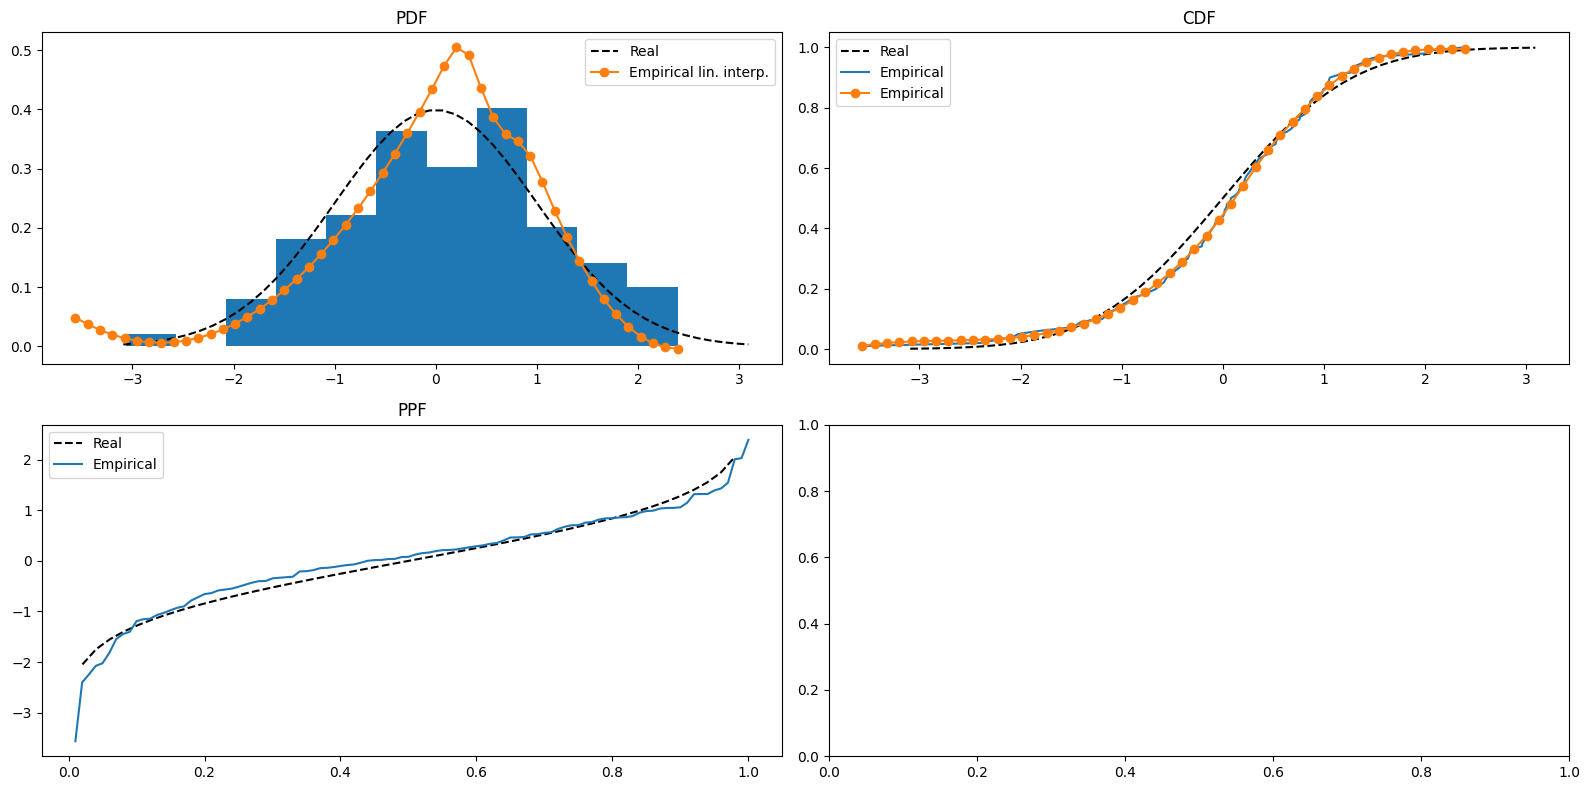

In [387]:
from scipy.interpolate import (
    make_interp_spline,
    PchipInterpolator,
    Akima1DInterpolator,
    UnivariateSpline,
    BSpline,
    make_smoothing_spline,
    kde_estimator,
)


np.random.seed(1234)
distr = stats.norm(loc=0.0, scale=1.0)
x = np.linspace(*distr.ppf([0.001, 1 - 0.001]))
p = np.linspace(0, 1)

samples = distr.rvs(size=100)
sorted_samples = np.sort(samples)


dens, bin_edges = np.histogram(samples, bins="auto", density=True)
cdf_empirical = np.arange(1, len(samples) + 1) / len(samples)
print(cdf_empirical[[0, 1, -2, -1]])

x_interp = np.linspace(sorted_samples.min(), sorted_samples.max(), 50)

# smoothing spline
cdf_fun = UnivariateSpline(sorted_samples, cdf_empirical, s=0.01)
dens_from_cdf = cdf_fun.derivative(1)(x_interp)
# cdf_fun = make_smoothing_spline(sorted_samples, cdf_empirical, lam=0.1)
# dens_from_cdf = cdf_fun.derivative(1)(x_interp)

# # piecewise linear interpolation
# cdf_fun = lambda x_: np.interp(x_, sorted_samples[::10], cdf_empirical[::10])

cdf_interp = cdf_fun(x_interp)
# dens_from_cdf = np.array(((cdf_interp[1:] - cdf_interp[:-1]) / np.diff(x_interp)[0] / 2).tolist() + [0.0])


fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(16, 8))
axs = axs.flat
axs[0].set_title("PDF")
axs[0].plot(x, distr.pdf(x), "k--", label="Real")
axs[0].hist(data, bins=bin_edges, density=True)
axs[0].plot(x_interp, dens_from_cdf, "-o", label="Empirical lin. interp.")
axs[0].legend()

axs[1].set_title("CDF")
axs[1].plot(x, distr.cdf(x), "k--", label="Real")
axs[1].plot(sorted_samples, cdf_empirical, "-", label="Empirical")
axs[1].plot(x_interp, cdf_interp, "-o", label="Empirical")
axs[1].legend()

axs[2].set_title("PPF")
axs[2].plot(p, distr.ppf(p), "k--", label="Real")
axs[2].plot(cdf_empirical, sorted_samples, "-", label="Empirical")
axs[2].legend()

plt.tight_layout()
plt.show()

False


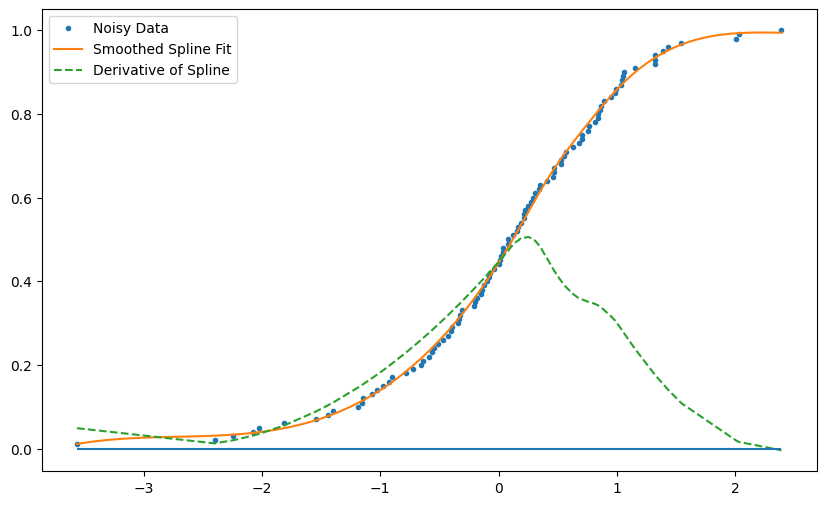

In [394]:
from scipy.interpolate import UnivariateSpline, PchipInterpolator

# Example x and y data
x = sorted_samples
y = cdf_empirical
x_eval = np.linspace(x.min(), x.max(), 100)

# Step 1: Fit a cubic spline with smoothing
smoothing_factor = 0.01  # Adjust based on the noise level
spline1 = UnivariateSpline(x, y, s=smoothing_factor)

# Step 2: Evaluate the spline for smoothing
y_smooth = spline1(x_eval)

spline = PchipInterpolator(x_eval, y_smooth)
y_smooth = spline(x_eval)

print(np.all(np.diff(y_smooth) >= 0.0))

# Step 3: Compute the derivative of the spline
spline_derivative = spline.derivative()
y_derivative = spline_derivative(x)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(x, y, ".", label="Noisy Data")
plt.plot(x_eval, y_smooth, "-", label="Smoothed Spline Fit")
plt.plot(x, y_derivative, "--", label="Derivative of Spline")
plt.hlines(0, x_eval.min(), x_eval.max())
plt.legend()
plt.show()


True


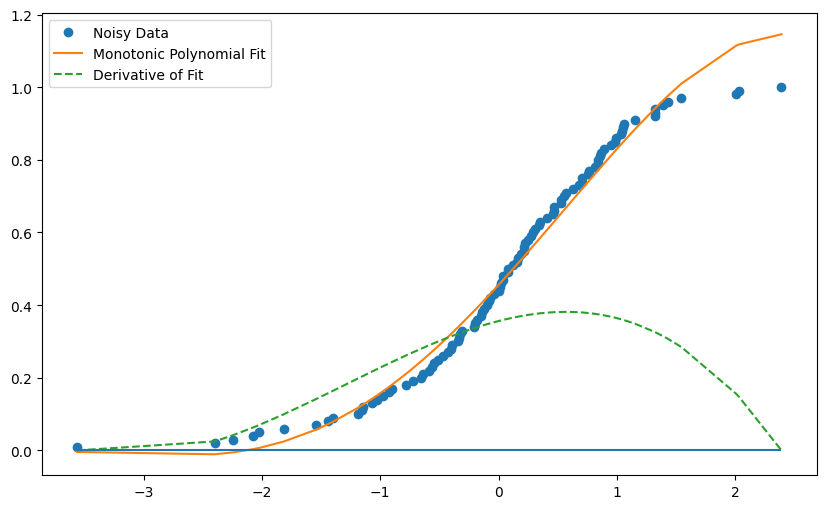

In [395]:
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt


# Polynomial degree
degree = 4


# Step 1: Define the polynomial function and its derivative
def polynomial_model(params, x):
    return sum(p * x**i for i, p in enumerate(params[::-1]))


def polynomial_derivative(params, x):
    return sum(i * p * x ** (i - 1) for i, p in enumerate(params[::-1]) if i > 0)


# Step 2: Define the loss function
def loss(params, x, y):
    return np.sum((polynomial_model(params, x) - y) ** 2)


# Step 3: Define the constraint for monotonicity
constraints = [{"type": "ineq", "fun": lambda params: polynomial_derivative(params, x)}]

# Initial guess for polynomial coefficients
initial_params = np.polyfit(x, y, degree)

# Step 4: Perform constrained optimization
result = minimize(loss, initial_params, args=(x, y), constraints=constraints)
fitted_params = result.x

# Step 5: Evaluate the fitted polynomial and its derivative
y_smooth = polynomial_model(fitted_params, x)
y_derivative = polynomial_derivative(fitted_params, x)

print(np.all(np.diff(y_smooth)))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(x, y, "o", label="Noisy Data")
plt.plot(x, y_smooth, "-", label="Monotonic Polynomial Fit")
plt.plot(x, y_derivative, "--", label="Derivative of Fit")
plt.hlines(0, x.min(), x.max())
plt.legend()
plt.show()


In [407]:
dir(IsotonicRegression)

['__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__sklearn_clone__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_build_f',
 '_build_request_for_signature',
 '_build_y',
 '_check_feature_names',
 '_check_input_data_shape',
 '_check_n_features',
 '_doc_link_module',
 '_doc_link_template',
 '_doc_link_url_param_generator',
 '_estimator_type',
 '_get_default_requests',
 '_get_doc_link',
 '_get_metadata_request',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_parameter_constraints',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_sklearn_auto_wrap_output_keys',
 '_transform',
 '_validate_data',
 '_validate_params',
 'fit',
 'fit_transform',


0.0 1.0
True


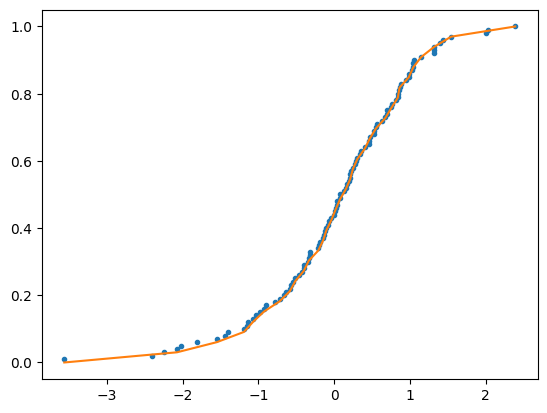

In [406]:
from sklearn.isotonic import IsotonicRegression

# Fit isotonic regression
iso_reg = IsotonicRegression(out_of_bounds="clip")
cdf_vals = iso_reg.fit_transform(x[::3], y[::3])
iso_reg.predict

# Scale to [0, 1] range
cdf_vals = (cdf_vals - np.min(cdf_vals)) / (np.max(cdf_vals) - np.min(cdf_vals))

print(cdf_vals.min(), cdf_vals.max())
print(np.all(np.diff(cdf_vals) >= 0.0))

plt.plot(x, y, ".")
plt.plot(x[::3], cdf_vals, "-")
# plt.plot(x_eval,iso_reg.predict(x_eval), "-")  # same as line above
plt.show()

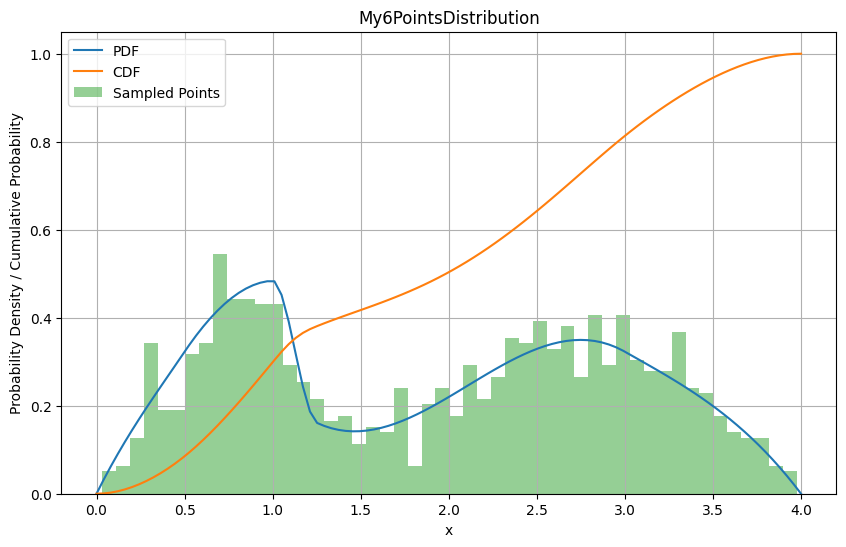

In [591]:
import numpy as np
from scipy import interpolate
from scipy.stats import rv_continuous
from scipy.interpolate import Akima1DInterpolator
from scipy.integrate import quad


class My6PointsDistribution(rv_continuous):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.x = np.array([0, 0.5, 1, 1.25, 3, 4])
        self.y = np.array([0, 2, 3, 1, 2, 0])
        self.spline = Akima1DInterpolator(self.x, self.y)
        self.integral, _ = quad(self.spline, self.x[0], self.x[-1])
        self.a = self.x[0]
        self.b = self.x[-1]

    def _pdf(self, x):
        return self.spline(x) / self.integral

    def _cdf(self, x):
        try:
            len(x)
            return np.array([quad(self._pdf, self.a, xi)[0] for xi in x])
        except TypeError:
            return quad(self._pdf, self.a, x)[0]

    def _rvs(self, size, random_state):
        u = np.random.rand(size[0])
        samples = np.zeros(size[0])

        # Use inverse interpolation to find x values corresponding to the uniform samples
        # ppf is the percent point function (inverse of cdf — percentiles).
        samples = interpolate.interp1d(
            [self._cdf(x_i) for x_i in np.linspace(x[0], x[-1], 200)],
            np.linspace(x[0], x[-1], 200),
        )(u)
        return samples


# Example usage
my_dist = My6PointsDistribution()

# PDF and CDF evaluation
x_eval = np.linspace(0, 4, 100)
pdf_values = my_dist.pdf(x_eval)
cdf_values = my_dist.cdf(x_eval)

# Random sampling (using the inherited rvs method)
samples = my_dist.rvs(size=1000)


# --- Plotting ---
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(x_eval, pdf_values, label="PDF")
plt.plot(x_eval, cdf_values, label="CDF")
plt.hist(samples, bins=50, density=True, alpha=0.5, label="Sampled Points")
plt.xlabel("x")
plt.ylabel("Probability Density / Cumulative Probability")
plt.title("My6PointsDistribution")
plt.legend()
plt.grid(True)
plt.show()

In [644]:
best_counter = dict()
# extended_ends == all

                True: 1.2333
                 KDE: 1.4601
   Hist_extended_end: 1.3502
      Hist_extra_bin: 1.3512
    Hist_data_scaled: 1.2106
            Hist_all: 1.3040

('Hist_data_scaled', 1.2106221628000344)
{'Hist_all': 9, 'Hist_data_scaled': 8, 'Hist_extra_bin': 6, 'Hist_extended_end': 6, 'KDE': 2}


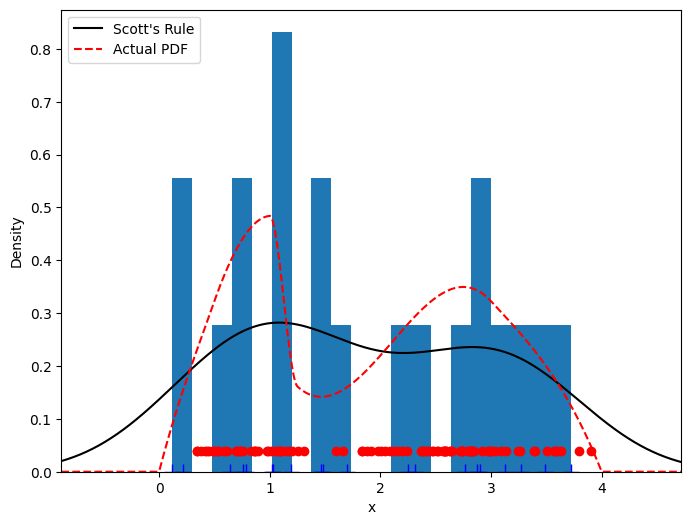

In [ ]:
# loc1, scale1, size1 = (-2, 0.001, 32)
# loc2, scale2, size2 = (+2, 0.005, 50)
# # loc1, scale1, size1 = (-2, 1, 32)
# # loc2, scale2, size2 = (2, 0.2, 50)
# # loc1, scale1, size1 = (-2, 1, 175)
# # loc2, scale2, size2 = (2, 0.2, 50)

# distr1 = stats.cauchy(loc=loc1, scale=scale1)
# distr2 = stats.cauchy(loc=loc2, scale=scale2)
# samples = np.concatenate(
#     [
#         distr1.rvs(size=size1),
#         distr2.rvs(size=size2),
#     ]
# )
# data = np.concatenate(
#     [
#         distr1.rvs(size=size1 * 20),
#         distr2.rvs(size=size2 * 20),
#     ]
# )

samples = my_dist.rvs(size=20)
data = my_dist.rvs(size=100)

pdf = my_dist.pdf


x_eval = np.linspace(samples.min() - 1, samples.max() + 1, 500)

kde = stats.gaussian_kde(samples)


# def pdf(x_):
#     return (
#         distr1.pdf(x_) * float(size1) / samples.size
#         + distr2.pdf(x_) * float(size2) / samples.size
#     )


dens, bin_edges = np.histogram(samples, bins=20, density=True)

true_nll = -np.log(pdf(data)).mean()
method_values = {
    "KDE": -kde.logpdf(data).mean(),
    "Hist_extended_end": -log_likelihood_estimate_hist(samples, data, "extended_ends"),
    "Hist_extra_bin": -log_likelihood_estimate_hist(samples, data, "extra_bin"),
    "Hist_data_scaled": -log_likelihood_estimate_hist(samples, data, "data_scaled"),
    "Hist_all": -log_likelihood_estimate_hist_all(samples, data),
}

print(f"{'True':>20}: {true_nll:.4f}")
for k, v in method_values.items():
    print(f"{k:>20}: {v:.4f}")

print()
abs_diffs = np.abs(np.array(list(method_values.values())) - true_nll)
best = list(method_values.items())[np.argmin(abs_diffs)]
print(best)
best_counter[best[0]] = best_counter.get(best[0], 0) + 1
print(best_counter)


fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

ax.plot(data, 0.04 * np.ones(data.shape), "r.", ms=12)
ax.plot(samples, np.zeros(samples.shape), "b+", ms=12)
ax.plot(x_eval, kde(x_eval), "k-", label="Scott's Rule")
ax.plot(x_eval, pdf(x_eval), "r--", label="Actual PDF")
ax.hist(samples, bins=bin_edges, density=True)

ax.set_xlim([x_eval.min(), x_eval.max()])
ax.legend(loc=2)
ax.set_xlabel("x")
ax.set_ylabel("Density")
plt.show()

[0.  0.2 0.4 0.6 1. ] 5


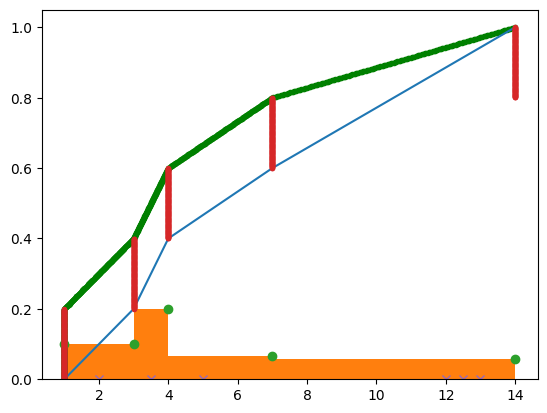

In [ ]:
samples = [1, 3, 4, 7, 14]

dens, bin_edges = np.histogram(samples, bins=samples, density=True)
dens2 = np.array([dens[0]] + dens.tolist())
cdf_from_hist = np.cumsum([0.0] + (dens * np.diff(bin_edges)).tolist())
print(cdf_from_hist, len(cdf_from_hist))

p = np.linspace(0, 1, 1000)
plt.plot(np.quantile(samples, p, method="interpolated_inverted_cdf"), p, "g.")
# plt.plot(np.zeros(len(data)), data, "x")
plt.plot(samples, cdf_from_hist)
plt.hist(samples, bins=bin_edges, density=True)
plt.plot(samples, dens2, "o")
plt.plot(np.quantile(samples, p, method="inverted_cdf"), p, ".")
plt.plot(data, np.zeros(len(data)), "x")
plt.show()

0.7999857104634339


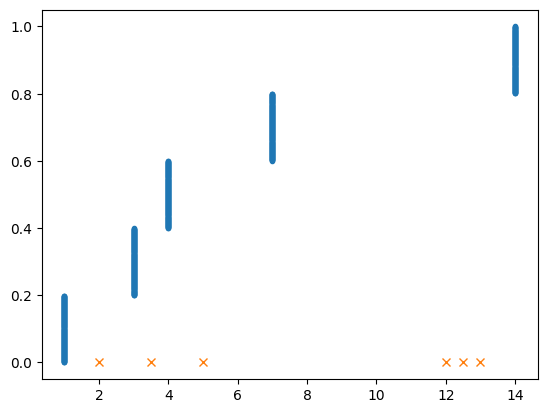

In [705]:
samples = [1, 3, 4, 7, 14]
data = [2, 3.5, 5, 12, 12.5, 13]

pdf_vals_inside_count = np.array([1, 2, 3, 4, 4, 4]) / len(data)
nll_inside_count = -np.log(pdf_vals_inside_count).mean()
print(nll_inside_count)

p = np.linspace(0, 1, 1000)
# plt.plot(p, np.quantile(samples, p, method="inverted_cdf"), ".")
# plt.plot(np.zeros(len(data)), data, "x")
plt.plot(np.quantile(samples, p, method="inverted_cdf"), p, ".")
plt.plot(data, np.zeros(len(data)), "x")
plt.show()

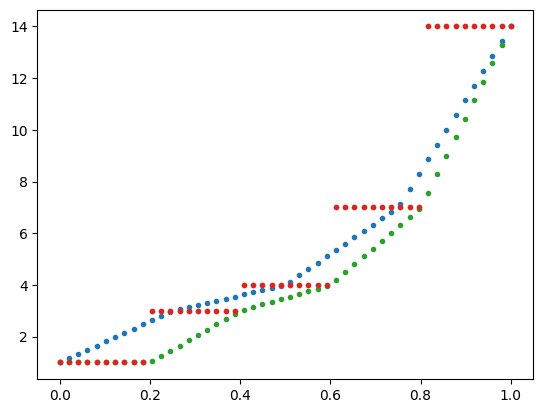

In [ ]:
samples = [1, 3, 4, 7, 14]

p = np.linspace(0, 1)

plt.plot(p, np.quantile(samples, p), ".")
plt.plot(p, np.quantile(samples, p, method="inverted_cdf"), ".")
plt.plot(p, np.quantile(samples, p, method="interpolated_inverted_cdf"), ".")
plt.plot(p, np.quantile(samples, p, method="averaged_inverted_cdf"), ".")

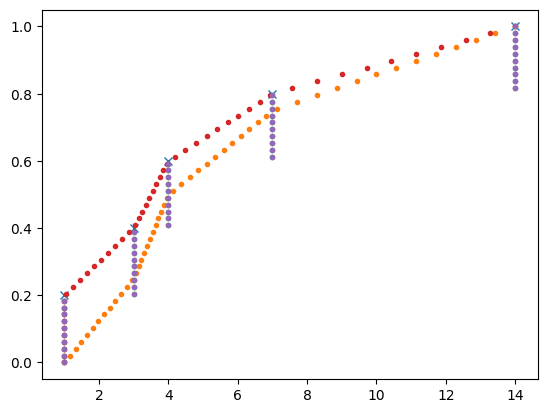

In [692]:
plt.plot(samples, np.arange(1, len(samples) + 1) / len(samples), "x")
plt.plot(np.quantile(samples, p), p, ".")
plt.plot(np.quantile(samples, p, method="inverted_cdf"), p, ".")
plt.plot(np.quantile(samples, p, method="interpolated_inverted_cdf"), p, ".")
plt.plot(np.quantile(samples, p, method="averaged_inverted_cdf"), p, ".")

     Real: 0.943132760063755
      NLL: 2.3068796546054853
      NLL: 2.3068796546054853
rel. dev.: 1.445975532065647


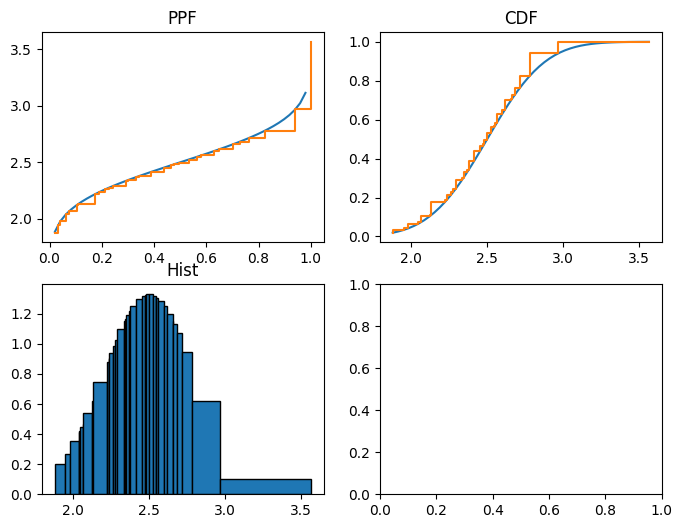

In [ ]:
n_quantiles = np.random.randint(1, 10)
distr = stats.norm(loc=2.5, scale=0.3)
probs = np.sort(np.random.uniform(0, 1, n_quantiles))
quantiles = distr.ppf(probs)

# probs = np.sort([0.0] + np.random.uniform(0, 1, n_quantiles - 2).tolist() + [1.0])
# quantiles = np.sort(np.random.uniform(0, 100, len(probs)))
# probs = np.array([0.0, 0.25, 0.5, 0.75, 1.0])
# quantiles = np.array([0, 2, 5, 7, 10])
hist_vals = np.diff(probs) / np.diff(quantiles)

data_point = np.random.uniform(quantiles.min(), quantiles.max())
bin_idx = np.searchsorted(quantiles, data_point) - 1
assert bin_idx >= 0
assert bin_idx < len(hist_vals)
fast_estimate = (probs[bin_idx + 1] - probs[bin_idx]) / (
    quantiles[bin_idx + 1] - quantiles[bin_idx]
)
print(f"      Real: {distr.pdf(data_point)}")
print(f"Likelihood: {hist_vals[bin_idx]} ({bin_idx})")
print(f"Likelihood: {fast_estimate}")

fig, axs = plt.subplots(2, 2, figsize=(8, 6))
axs = axs.flat
ps = np.linspace(0,1)
xs = np.linspace(quantiles.min(),quantiles.max())
axs[0].set_title("PPF")
axs[0].plot(ps, distr.ppf(ps))
axs[0].step(probs, quantiles, where="post")
axs[1].set_title("CDF")
axs[1].plot(xs, distr.cdf(xs))
axs[1].step(quantiles, probs, where="pre")
axs[2].set_title("Hist")
axs[2].bar(
    quantiles[:-1],
    hist_vals,
    width=np.diff(quantiles),
    bottom=0.0,
    align="edge",
    edgecolor="k",
)
plt.show()